# Facial Emotion Recognition Analysis Using FER-2013 Dataset

## Import Libraries

In [1]:
!pip install Pillow

In [2]:
!pip install tensorflow

In [3]:
from google.colab import drive
import os
import random
import shutil
import cv2
import albumentations as A
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns
from sklearn.metrics import mutual_info_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, PReLU, Add, UpSampling2D, LeakyReLU, Flatten, Dense, Lambda
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *

## Load Data

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
images_dir= '/content/drive/MyDrive/Data_Visualization/Course_Project/images/'

In [6]:
# Identify Classes (Labels) from Data Source

classes=os.listdir(images_dir)
count_classes=len(classes)
classes

['Fear', 'Angry', 'Neutral', 'Happy', 'Disgust']

##  Exploratory Data Analysis (EDA)

### Count the Total Number of Images and Number of Images at Each Class

In [7]:
def count_images(images_dir):
  total=0
  dict={}
  for directory in os.listdir(images_dir):
    c_total=len(os.listdir(images_dir+directory))
    dict[directory]=c_total
    total=total+c_total
  return total, dict

In [8]:
total_images,number_of_images_dict=count_images(images_dir)
print(f'Total Images: {total_images}')
print(f'Number of Images in each Class: {number_of_images_dict}')

Total Images: 16177
Number of Images in each Class: {'Fear': 2460, 'Angry': 2675, 'Neutral': 4131, 'Happy': 6539, 'Disgust': 372}


### Check the Data if It Is Balanced or Not using Bar Chart and Imbalanced Ratio

In [9]:
def plot_bar_image_at_each_class(images_dir):
    class_counts = {}

    # Count images in each class
    classes = os.listdir(images_dir)
    for class_name in classes:
        class_path = os.path.join(images_dir, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))

    # Sort class_counts by count descending
    sorted_class_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))

    classes = list(sorted_class_counts.keys())
    counts = list(sorted_class_counts.values())

    plt.figure(figsize=(8,6))
    bars = plt.bar(classes, counts)

    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
                 ha='center', va='bottom')

    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Number of Images per Class')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

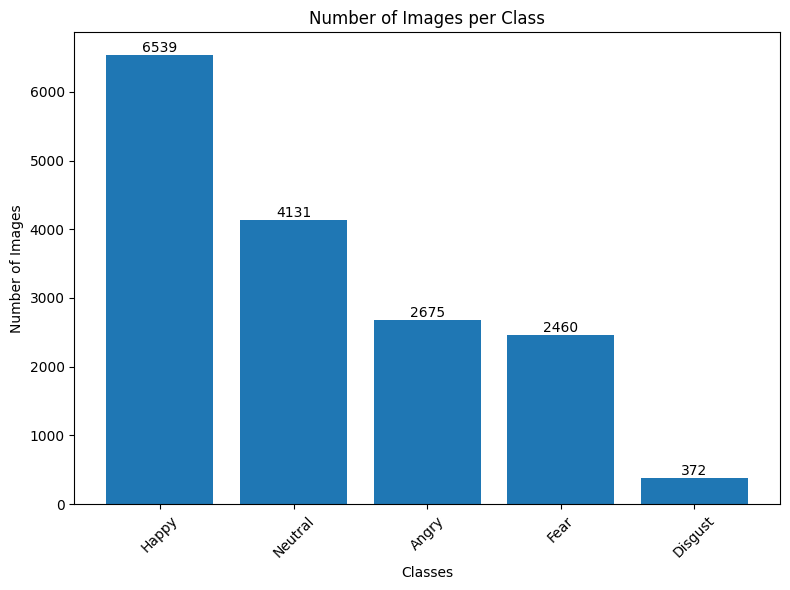

In [10]:
plot_bar_image_at_each_class(images_dir)

In [11]:
def imbalanced_ratio(image_count_dict):
  max_count_class=max(image_count_dict.values())
  min_count_class=min(image_count_dict.values())
  ratio=max_count_class/min_count_class
  return ratio

In [12]:
imbalanced_ratio=imbalanced_ratio(number_of_images_dict)
print(f"Imbalanced Ratio= {imbalanced_ratio:.2f}")

Imbalanced Ratio= 17.58


#### Conclusion and Insights (Class Imbalance):
  
##### Bar Chart:
    1. The number of images across all classes is not equal.  
      
    2. There is a significant disparity in the number of images for the classes: Happy, Neutral, Angry, Fear, and Disgust. All classes contain more than 2,000 images except for Disgust, which has only 367 images.  
      
    3. This substantial class imbalance could affect further analysis and the performance of machine learning models.  

##### Imbalance Ratio Computation:
  1. The imbalance ratio is 17.72, indicating that the most common class (Happy) has over 17 times more representations than the least common class (Disgust).  
    
  2. Considering a threshold ratio of 10% (0.1), the imbalance ratio of 17.72 is significantly higher than this threshold, demonstrating a severe imbalance between the maximum and minimum class.  



### Pixel Analysis Intensity by Histogram

In [13]:
def pixel_intensity_analysis_per_class(images_dir, classes):
    num_classes = len(classes)
    cols = 3
    rows = (num_classes + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()
    for idx, class_name in enumerate(classes):
        pixel_intensities = []
        class_path = os.path.join(images_dir, class_name)
        class_images = os.listdir(class_path)

        for img_name in class_images:
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path).convert('L')
            img_array = np.array(img)
            pixel_intensities.extend(img_array.flatten())

        sns.histplot(pixel_intensities, bins=256, kde=True, ax=axes[idx])
        axes[idx].set_xlabel('Pixel Intensity')
        axes[idx].set_ylabel('Frequency')
        axes[idx].set_title(f'Class: {class_name}')

    # Hide any empty subplots
    for i in range(idx + 1, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()



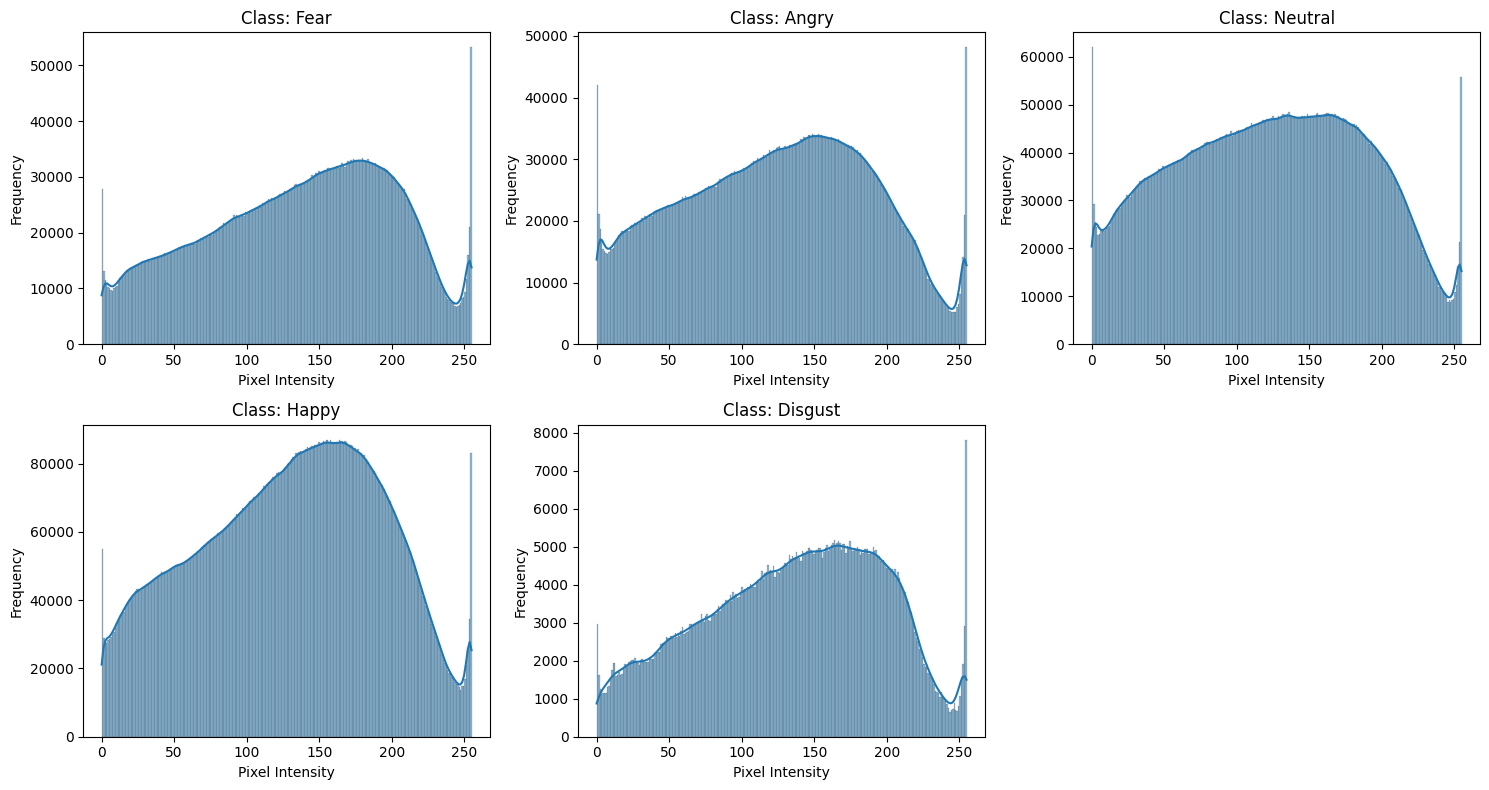

In [14]:
pixel_intensity_analysis_per_class(images_dir, classes)

### Conclusion and Insights (Pixel Intensity Analysis):

1. The pixel values for the different classes range from 0 to 255.

2. While all classes exhibit extreme outliers, the histogram distribution shows that the pixel values are primarily concentrated at 0 and 255.

3. The "Happy" class has the highest overall frequency, exceeding 80,000, indicating that it contains more images than the other classes.

4. In contrast, the "Disgust" class displays significantly lower pixel intensity compared to others, with only about 7,000 images.

5. The "Disgust" class accounts for approximately 5% of the total image count across all classes.

### Compute Mutual Information Score Between Classes to Find Relationship (Correlation)

In [14]:
def load_random_image_from_class(class_name):
    class_path = os.path.join(images_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.endswith('.jpg') or f.endswith('.png')]
    random_file = random.choice(image_files)
    img_path = os.path.join(class_path, random_file)
    img = Image.open(img_path).convert('L')
    img = np.array(img)
    return img, random_file

In [15]:
class_folders = [d for d in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, d))]

def calculate_mutual_information(img1, img2):
    img1_flat = img1.flatten()
    img2_flat = img2.flatten()
    mi = mutual_info_score(img1_flat, img2_flat)
    return mi


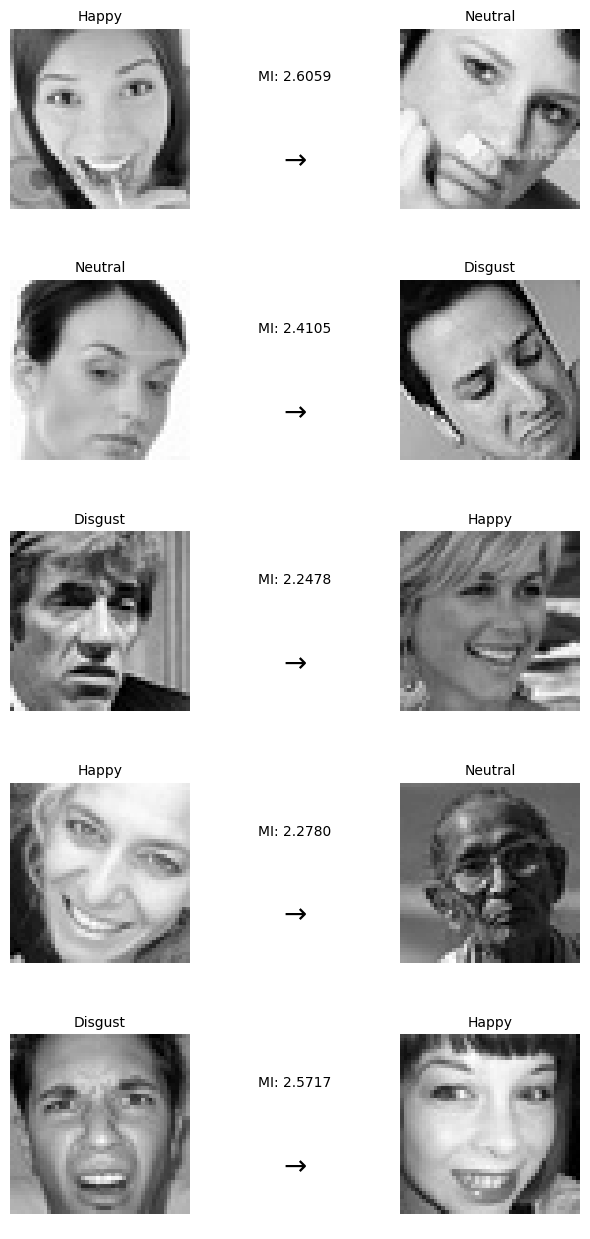

In [16]:
# Show sample of images with Mutual Information

def show_image_pairs_with_mi(num_pairs=5):
    fig, axarr = plt.subplots(num_pairs, 3, figsize=(6, num_pairs * 2.5))

    for idx in range(num_pairs):
        class1 = random.choice(class_folders)
        class2 = random.choice(class_folders)

        img1, _ = load_random_image_from_class(class1)
        img2, _ = load_random_image_from_class(class2)
        mi_value = calculate_mutual_information(img1, img2)

        # Left image
        axarr[idx, 0].imshow(img1, cmap='gray')
        axarr[idx, 0].set_title(f'{class1}', fontsize=10)
        axarr[idx, 0].axis('off')

        # Arrow with MI score above it
        axarr[idx, 1].text(0.5, 0.7, 'MI: {:.4f}'.format(mi_value), fontsize=10, ha='center', va='center')
        axarr[idx, 1].text(0.5, 0.3, '→', fontsize=20, ha='center', va='center')
        axarr[idx, 1].axis('off')

        # Right image
        axarr[idx, 2].imshow(img2, cmap='gray')
        axarr[idx, 2].set_title(f'{class2}', fontsize=10)
        axarr[idx, 2].axis('off')

    plt.tight_layout(h_pad=3.0)
    plt.show()



show_image_pairs_with_mi(num_pairs=5)

### Conclusion and Insights (Mutual Information of Two Images):

  This mutual information to show the similarity between pairs of facial expression by comparing the features and patterns:
    1. Mutual Information (MI) values in this samples ranges between 2.5 and 2.8 which is relatively very close to each other.

    2. This outcome suggests that FER-13 dataset share some

## Data Preprocessing

## Remove Outliers

In [17]:
def remove_outliers(images_dir, image_size=(48, 48), iqr_multiplier=1.0, preview=False):
    for class_name in os.listdir(images_dir):
        class_dir = os.path.join(images_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        print(f"\nClass: {class_name}")
        stds = []
        image_paths = []

        # Step 1: Collect standard deviation per image
        for img_name in os.listdir(class_dir):
            if not img_name.lower().endswith(('jpg', 'jpeg', 'png')):
                continue
            img_path = os.path.join(class_dir, img_name)
            try:
                img = Image.open(img_path).convert('L').resize(image_size)
                pixel_array = np.array(img)
                std_val = pixel_array.std()
                stds.append(std_val)
                image_paths.append(img_path)
            except Exception as e:
                print(f"Error loading image {img_name}: {e}")
                continue

        if len(stds) == 0:
            print("No valid images found.")
            continue

        stds = np.array(stds)

        # Step 2: Compute IQR bounds
        Q1 = np.percentile(stds, 25)
        Q3 = np.percentile(stds, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR

        print(f"IQR bounds (std): {lower_bound:.2f} to {upper_bound:.2f}")

        # Step 3: Identify and optionally preview outliers
        outliers = [(p, s) for p, s in zip(image_paths, stds) if s < lower_bound or s > upper_bound]
        print(f"Identified {len(outliers)} outlier(s).")

        if preview and outliers:
            print("Previewing a few outliers...")
            fig, axes = plt.subplots(1, min(5, len(outliers)), figsize=(15, 3))
            for ax, (path, std_val) in zip(axes, outliers[:5]):
                img = Image.open(path).convert('L')
                ax.imshow(img, cmap='gray')
                ax.set_title(f"Std: {std_val:.2f}")
                ax.axis('off')
            plt.show()

        # Step 4: Delete outliers
        removed_count = 0
        for img_path, _ in outliers:
            try:
                os.remove(img_path)
                removed_count += 1
            except Exception as e:
                print(f"Failed to remove {img_path}: {e}")

        print(f"Removed {removed_count} outlier image(s) from '{class_name}'.")
    return images_dir




In [18]:
images_dir=remove_outliers(images_dir)
images_dir


Class: Fear
IQR bounds (std): 27.72 to 81.05
Identified 3 outlier(s).
Removed 3 outlier image(s) from 'Fear'.

Class: Angry
IQR bounds (std): 29.53 to 79.81
Identified 2 outlier(s).
Removed 2 outlier image(s) from 'Angry'.

Class: Neutral
IQR bounds (std): 24.99 to 83.86
Identified 3 outlier(s).
Removed 3 outlier image(s) from 'Neutral'.

Class: Happy
IQR bounds (std): 27.61 to 78.56
Identified 0 outlier(s).
Removed 0 outlier image(s) from 'Happy'.

Class: Disgust
IQR bounds (std): 21.38 to 80.36
Identified 0 outlier(s).
Removed 0 outlier image(s) from 'Disgust'.


'/content/drive/MyDrive/Data_Visualization/Course_Project/images/'

### Resolution Enhancement Using Super-Resolution GANs (SRGANs)

In [19]:
original_images_dir = '/content/drive/MyDrive/Data_Visualization/Course_Project/images/'
srgan_output_dir = '/content/drive/MyDrive/Data_Visualization/Course_Project/srgan_images/'
augmented_output_dir = '/content/drive/MyDrive/Data_Visualization/Course_Project/augmented_images/'

# Modification

In [20]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, PReLU, Add, MaxPooling2D,
    UpSampling2D, Flatten, Dense, Dropout, Concatenate
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# Data preprocessing functions
def load_and_preprocess_image(image_path, lr_size=(48, 48), hr_size=(96, 96)):
    """Load and preprocess a single image"""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None, None

    # Apply histogram equalization
    img = cv2.equalizeHist(img)

    # Create LR and HR versions
    lr = cv2.resize(img, lr_size)
    hr = cv2.resize(img, hr_size)

    # Normalize to [-1, 1] for tanh activation
    lr = (lr.astype(np.float32) / 127.5) - 1
    hr = (hr.astype(np.float32) / 127.5) - 1

    return lr[..., np.newaxis], hr[..., np.newaxis]

def prepare_dataset(data_dir, lr_size=(48, 48), hr_size=(96, 96)):
    """Prepare the complete dataset"""
    X_lr, X_hr, y = [], [], []
    class_names = sorted(os.listdir(data_dir))
    class_map = {cls: idx for idx, cls in enumerate(class_names)}

    for cls in class_names:
        cls_path = os.path.join(data_dir, cls)
        if not os.path.isdir(cls_path):
            continue

        for fname in os.listdir(cls_path):
            lr_img, hr_img = load_and_preprocess_image(
                os.path.join(cls_path, fname),
                lr_size,
                hr_size
            )
            if lr_img is not None:
                X_lr.append(lr_img)
                X_hr.append(hr_img)
                y.append(class_map[cls])

    return (np.array(X_lr), np.array(X_hr),
            to_categorical(y, num_classes=len(class_names)),
            class_names)

# Model architectures
def residual_dense_block(x, filters=64):
    """Improved Residual Dense Block"""
    x1 = Conv2D(filters, 3, padding='same')(x)
    x1 = PReLU(shared_axes=[1, 2])(x1)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(filters, 3, padding='same')(Concatenate()([x, x1]))
    x2 = PReLU(shared_axes=[1, 2])(x2)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(filters, 3, padding='same')(Concatenate()([x, x1, x2]))
    x3 = PReLU(shared_axes=[1, 2])(x3)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(filters, 1, padding='same')(Concatenate()([x, x1, x2, x3]))
    return Add()([x, x4])

def build_generator(input_shape=(48, 48, 1), filters=64, n_blocks=8):
    """Improved Generator Architecture"""
    inputs = Input(shape=input_shape)

    # Initial feature extraction
    x = Conv2D(filters, 3, padding='same')(inputs)
    x = PReLU(shared_axes=[1, 2])(x)
    skip = x

    # Residual Dense Blocks
    for _ in range(n_blocks):
        x = residual_dense_block(x, filters)

    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, skip])

    # Upsampling
    x = UpSampling2D()(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = PReLU(shared_axes=[1, 2])(x)

    # Output
    output = Conv2D(1, 3, padding='same', activation='tanh')(x)

    return Model(inputs, output)

def build_discriminator(input_shape=(96, 96, 1)):
    """Improved Discriminator Architecture"""
    inputs = Input(shape=input_shape)
    x = inputs

    for filters in [64, 128, 256, 512]:
        x = Conv2D(filters, 3, strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = PReLU()(x)
        x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.4)(x)
    output = Dense(1, activation='sigmoid')(x)

    return Model(inputs, output)

def build_classifier(input_shape=(96, 96, 3), num_classes=5):
    """Improved Classifier Architecture"""
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(64, 3, padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Dropout(0.25),

        Conv2D(128, 3, padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(128, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Dropout(0.25),

        Conv2D(256, 3, padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(256, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Dropout(0.25),

        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    return model

# Training setup
def create_callbacks(model_name):
    return [
        ModelCheckpoint(
            f'{model_name}_best.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]

def compile_joint_model(generator, discriminator, classifier, lr_shape=(48, 48, 1), hr_shape=(96, 96, 1)):
    """Compile the joint GAN model"""
    # Make sure generator is trainable
    generator.trainable = True
    discriminator.trainable = False
    classifier.trainable = False

    lr_input = Input(shape=lr_shape)
    hr_input = Input(shape=hr_shape)

    # Generate SR image
    sr_output = generator(lr_input)

    # Discriminator output
    validity = discriminator(sr_output)

    # Prepare input for classifier (convert to RGB)
    sr_rgb = Concatenate()([sr_output]*3)

    # Classifier output
    class_output = classifier(sr_rgb)

    joint_model = Model([lr_input, hr_input], [validity, class_output])
    joint_model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss=['binary_crossentropy', 'categorical_crossentropy'],
        loss_weights=[1e-3, 1],
        metrics=[['accuracy'], ['accuracy']]  # Specify metrics for each output
    )

    return joint_model

def train_models(data_dir, epochs=50, batch_size=32):
    # Prepare data
    X_lr, X_hr, y, class_names = prepare_dataset(data_dir)
    (lr_train, lr_test, hr_train, hr_test,
     y_train, y_test) = train_test_split(X_lr, X_hr, y, test_size=0.2)

    # Build models
    G = build_generator()
    D = build_discriminator()
    C = build_classifier(num_classes=len(class_names))

    # Compile individual models
    D.compile(
        optimizer=Adam(2e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    C.compile(
        optimizer=Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Compile joint model
    joint_model = compile_joint_model(G, D, C)

    # Training loop
    steps_per_epoch = len(lr_train) // batch_size

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        for step in range(steps_per_epoch):
            # Get batch
            idx = np.random.randint(0, len(lr_train), batch_size)
            lr_batch = lr_train[idx]
            hr_batch = hr_train[idx]
            y_batch = y_train[idx]

            # Train discriminator
            D.trainable = True
            sr_batch = G.predict(lr_batch, verbose=0)

            d_loss_real = D.train_on_batch(hr_batch, np.ones((batch_size, 1)))
            d_loss_fake = D.train_on_batch(sr_batch, np.zeros((batch_size, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train generator through joint model
            D.trainable = False
            g_loss = joint_model.train_on_batch(
                [lr_batch, hr_batch],
                [np.ones((batch_size, 1)), y_batch]
            )

            if step % 10 == 0:
                print(f"Step {step}/{steps_per_epoch}")
                print(f"D loss: {d_loss[0]:.4f}, D acc: {d_loss[1]:.4f}")
                print(f"G loss: {g_loss[0]:.4f}, G acc: {g_loss[1]:.4f}")
                print(f"C acc: {g_loss[3]:.4f}")

        # Validation
        sr_test = G.predict(lr_test, verbose=0)
        sr_test_rgb = np.repeat(sr_test, 3, axis=-1)

        # Evaluate models
        d_val_loss = D.evaluate(sr_test, np.zeros((len(sr_test), 1)), verbose=0)
        c_val_loss = C.evaluate(sr_test_rgb, y_test, verbose=0)

        print("\nValidation Results:")
        print(f"D loss: {d_val_loss[0]:.4f}, D acc: {d_val_loss[1]:.4f}")
        print(f"C loss: {c_val_loss[0]:.4f}, C acc: {c_val_loss[1]:.4f}")

    return G, D, C

# Evaluation metrics
def evaluate_models(G, D, C, lr_test, hr_test, y_test):
    # Generate SR images
    sr_test = G.predict(lr_test)
    sr_test_rgb = np.repeat(sr_test, 3, axis=-1)

    # Get predictions
    y_pred = np.argmax(C.predict(sr_test_rgb), axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)

    print("\nFinal Evaluation Metrics:")
    print(f"Accuracy : {accuracy*100:.2f}%")
    print(f"Precision: {precision*100:.2f}%")
    print(f"Recall   : {recall*100:.2f}%")
    print(f"F1 Score : {f1*100:.2f}%")
    print("\nConfusion Matrix:")
    print(cm)

    return accuracy, precision, recall, f1, cm

# Main execution
if __name__ == "__main__":
    # Train models
    G, D, C = train_models(original_images_dir)

    # Load test data
    X_lr, X_hr, y, class_names = prepare_dataset(original_images_dir)
    _, lr_test, _, hr_test, _, y_test = train_test_split(X_lr, X_hr, y, test_size=0.2)

    # Evaluate
    metrics = evaluate_models(G, D, C, lr_test, hr_test, y_test)

Streaming output truncated to the last 5000 lines.
D loss: 1.7447, D acc: 0.8521
G loss: 1.5877, G acc: 2.2503
C acc: 0.6491
Step 290/404
D loss: 1.6936, D acc: 0.8564
G loss: 1.5876, G acc: 2.2493
C acc: 0.6492
Step 300/404
D loss: 1.6454, D acc: 0.8605
G loss: 1.5876, G acc: 2.2490
C acc: 0.6494
Step 310/404
D loss: 1.5998, D acc: 0.8644
G loss: 1.5876, G acc: 2.2506
C acc: 0.6493
Step 320/404
D loss: 1.5567, D acc: 0.8680
G loss: 1.5876, G acc: 2.2519
C acc: 0.6492
Step 330/404
D loss: 1.5159, D acc: 0.8715
G loss: 1.5876, G acc: 2.2523
C acc: 0.6492
Step 340/404
D loss: 1.4772, D acc: 0.8748
G loss: 1.5876, G acc: 2.2514
C acc: 0.6493
Step 350/404
D loss: 1.4404, D acc: 0.8779
G loss: 1.5876, G acc: 2.2516
C acc: 0.6493
Step 360/404
D loss: 1.4053, D acc: 0.8809
G loss: 1.5876, G acc: 2.2504
C acc: 0.6495
Step 370/404
D loss: 1.3720, D acc: 0.8837
G loss: 1.5876, G acc: 2.2485
C acc: 0.6498
Step 380/404
D loss: 1.3402, D acc: 0.8864
G loss: 1.5876, G acc: 2.2467
C acc: 0.6500
Step 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# SRGANS Modification 2

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ================== Improved SRGAN Architecture ==================
def build_vgg_loss_model():
    vgg = VGG19(include_top=False, weights='imagenet', input_shape=(96,96,3))
    return Model(vgg.input, vgg.get_layer('block3_conv4').output)

def residual_block(x):
    initial = x
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.PReLU(shared_axes=[1,2])(x)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    return layers.Add()([initial, x])

def build_generator(input_shape=(48,48,1)):
    inputs = layers.Input(shape=input_shape)

    # Initial features
    x = layers.Conv2D(64, 9, padding='same')(inputs)
    x = layers.PReLU(shared_axes=[1,2])(x)
    initial = x

    # Residual blocks
    for _ in range(16):
        x = residual_block(x)

    # Final processing
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([initial, x])

    # Upsampling
    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(x)
    x = layers.PReLU(shared_axes=[1,2])(x)

    output = layers.Conv2D(1, 9, padding='same', activation='tanh')(x)
    return Model(inputs, output)

def build_discriminator(input_shape=(96,96,1)):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, 3, padding='same')(inputs)
    x = layers.LeakyReLU(0.2)(x)

    for filters in [64, 128, 128, 256, 256]:
        x = layers.Conv2D(filters, 3, strides=2, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(0.2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1024)(x)
    x = layers.LeakyReLU(0.2)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    return Model(inputs, output)

# ================== Enhanced Classifier ==================
def build_classifier(input_shape=(96,96,1), num_classes=7):
    inputs = layers.Input(shape=input_shape)

    # Convert to 3 channels
    x = layers.Conv2D(3, 1, padding='same')(inputs)

    # Use pre-trained base
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(96,96,3),
        pooling='avg'
    )
    x = base_model(x)

    # Custom head
    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    return Model(inputs, output)

# ================== Custom Training Logic ==================
class SRGAN_Trainer:
    def __init__(self, lr_shape=(48,48,1), hr_shape=(96,96,1)):
        self.vgg = build_vgg_loss_model()
        self.vgg.trainable = False

        # Build components
        self.generator = build_generator(lr_shape)
        self.discriminator = build_discriminator(hr_shape)
        self.classifier = build_classifier(hr_shape)

        # Compile discriminators
        self.discriminator.compile(
            optimizer=Adam(1e-4),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        # Build joint model
        self._build_joint_model()

    def _build_joint_model(self):
        lr_input = layers.Input(shape=(48,48,1))
        hr_input = layers.Input(shape=(96,96,1))

        # Generate SR image
        sr_output = self.generator(lr_input)

        # Discriminator validity
        validity = self.discriminator(sr_output)

        # VGG perceptual loss
        sr_rgb = layers.Concatenate()([sr_output]*3)
        hr_rgb = layers.Concatenate()([hr_input]*3)
        vgg_sr = self.vgg(sr_rgb)
        vgg_hr = self.vgg(hr_rgb)

        # Classification output
        class_output = self.classifier(sr_output)

        # Combined model
        self.joint_model = Model(
            inputs=[lr_input, hr_input],
            outputs=[validity, class_output, vgg_sr]
        )

        self.joint_model.compile(
            optimizer=Adam(1e-4),
            loss=['binary_crossentropy', 'categorical_crossentropy', 'mse'],
            loss_weights=[1e-3, 1, 0.1],
            metrics={
                'classifier': ['accuracy', Precision(), Recall()]
            }
        )

    def train(self, X_lr, X_hr, y, epochs=100, batch_size=32):
        # Pretrain classifier
        print("Pretraining classifier...")
        self.classifier.compile(
            optimizer=Adam(1e-3),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        self.classifier.fit(
            X_hr,
            y,
            batch_size=32,
            epochs=10,
            validation_split=0.2
        )

        # Main training loop
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            # Train discriminator
            idx = np.random.randint(0, X_lr.shape[0], batch_size)
            real_imgs = X_hr[idx]

            sr_imgs = self.generator.predict(X_lr[idx])

            d_loss_real = self.discriminator.train_on_batch(real_imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(sr_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train generator via joint model
            g_loss = self.joint_model.train_on_batch(
                [X_lr[idx], X_hr[idx]],
                [valid, y[idx], real_imgs]
            )

            # Print progress
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"D Loss: {d_loss[0]:.4f} | G Loss: {g_loss[0]:.4f}")
            print(f"Class Accuracy: {g_loss[3]:.2%} | Precision: {g_loss[4]:.2%}")

# ================== Enhanced Data Pipeline ==================
def load_fer13(dataset_path):
    # Implement your FER-2013 loading logic here
    # Should return (X_lr, X_hr), y with proper preprocessing
    pass

# ================== Usage Example ==================
if __name__ == "__main__":
    # Load dataset
    (X_lr, X_hr), y = load_fer13("path/to/fer2013")
    y = tf.keras.utils.to_categorical(y)

    # Initialize trainer
    trainer = SRGAN_Trainer()

    # Start training
    trainer.train(X_lr, X_hr, y, epochs=100)

    # Evaluate final performance
    sr_images = trainer.generator.predict(X_lr)
    preds = trainer.classifier.predict(sr_images)
    y_pred = np.argmax(preds, axis=1)
    y_true = np.argmax(y, axis=1)

    print("Final Evaluation:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.2%}")
    print(f"F1 Score: {f1_score(y_true, y_pred, average='weighted'):.2%}")

###Augmentationof Images to Balance The Classes

In [ ]:
# def augment_and_merge_images(images_dir, output_dir, target_count):
#     reset_directory(output_dir)  # Clear augmented folder at each run

#     transform = A.Compose([
#         A.HorizontalFlip(p=0.5),
#         A.RandomBrightnessContrast(p=0.2),
#         A.Rotate(limit=15, p=0.5),
#         A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
#         A.GaussNoise(p=0.2),
#     ])

#     for class_name in os.listdir(images_dir):
#         class_input_path = os.path.join(images_dir, class_name)
#         if not os.path.isdir(class_input_path):
#             continue

#         output_class_path = os.path.join(output_dir, class_name)
#         os.makedirs(output_class_path, exist_ok=True)

#         images = [img for img in os.listdir(class_input_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
#         current_count = len(images)
#         needed = target_count - current_count

#         print(f"{class_name}: {current_count} images → augmenting {needed} to reach {target_count}")

#         # Copy originals
#         for img_name in images:
#             src_path = os.path.join(class_input_path, img_name)
#             dst_path = os.path.join(output_class_path, img_name)
#             shutil.copy2(src_path, dst_path)

#         # Augment
#         i = 0
#         while i < needed:
#             img_name = images[i % len(images)]
#             img_path = os.path.join(class_input_path, img_name)
#             image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#             if image is None:
#                 continue
#             image = image.astype(np.float32) / 255.0
#             augmented = transform(image=image)['image']
#             aug_img = (augmented * 255).astype(np.uint8)
#             aug_name = f"{os.path.splitext(img_name)[0]}_aug{i+1}.png"
#             aug_path = os.path.join(output_class_path, aug_name)
#             cv2.imwrite(aug_path, aug_img)
#             i += 1

#         print(f"{class_name}: Finished with {len(os.listdir(output_class_path))} total images.")


In [ ]:
# --------- Augment and Merge Images ---------
def augment_and_merge_images(images_dir, output_dir, target_count):
    reset_directory(output_dir)
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Rotate(limit=15, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
        A.GaussNoise(p=0.2),
    ])
    for class_name in os.listdir(images_dir):
        class_input_path = os.path.join(images_dir, class_name)
        if not os.path.isdir(class_input_path):
            continue
        output_class_path = os.path.join(output_dir, class_name)
        os.makedirs(output_class_path, exist_ok=True)
        images = [img for img in os.listdir(class_input_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
        current_count = len(images)
        needed = target_count - current_count
        print(f"{class_name}: {current_count} images → augmenting {needed} to reach {target_count}")
        for img_name in images:
            src_path = os.path.join(class_input_path, img_name)
            dst_path = os.path.join(output_class_path, img_name)
            shutil.copy2(src_path, dst_path)
        i = 0
        while i < needed:
            img_name = images[i % len(images)]
            img_path = os.path.join(class_input_path, img_name)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                continue
            image = image.astype(np.float32) / 255.0
            augmented = transform(image=image)['image']
            aug_img = cv2.resize((augmented * 255).astype(np.uint8), (96, 96))
            aug_name = f"{os.path.splitext(img_name)[0]}_aug{i+1}.png"
            aug_path = os.path.join(output_class_path, aug_name)
            cv2.imwrite(aug_path, aug_img)
            i += 1
        print(f"{class_name}: Finished with {len(os.listdir(output_class_path))} total images.")

In [ ]:
# # --- Build Models ---
# lr_shape = (48, 48, 1)
# hr_shape = (192, 192, 1)
# generator = build_generator(input_shape=lr_shape)
# discriminator = build_discriminator(input_shape=hr_shape)
# vgg = build_vgg(input_shape=(192, 192, 3))
# srgan = compile_srgan(generator, discriminator, vgg, lr_shape, hr_shape)

# # --- Load Original Images ---
# lr_imgs, hr_imgs, image_names, class_labels = load_images(original_images_dir)


# # --- Augment the SRGAN Output, Save Final Results ---
# target_count = 6834
# augment_and_merge_images(srgan_output_dir, augmented_output_dir, target_count)


In [ ]:
# import os
# import shutil
# import cv2
# import numpy as np
# import albumentations as A

# def reset_directory(path):
#     if os.path.exists(path):
#         shutil.rmtree(path)
#     os.makedirs(path, exist_ok=True)

# def augment_and_merge_images(images_dir, output_dir, target_count):
#     reset_directory(output_dir)  # Force refresh

#     transform = A.Compose([
#         A.HorizontalFlip(p=0.5),
#         A.RandomBrightnessContrast(p=0.2),
#         A.Rotate(limit=15, p=0.5),
#         A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
#         A.GaussNoise(p=0.2),
#     ])

#     for class_name in os.listdir(images_dir):
#         class_input_path = os.path.join(images_dir, class_name)
#         if not os.path.isdir(class_input_path):
#             continue

#         output_class_path = os.path.join(output_dir, class_name)
#         # os.makedirs(output_class_path, exist_ok=True)

#         images = [img for img in os.listdir(class_input_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
#         current_count = len(images)
#         needed = target_count - current_count

#         print(f"{class_name}: {current_count} images → augmenting {needed} to reach {target_count}")

#         # Copy original images
#         for img_name in images:
#             src_path = os.path.join(class_input_path, img_name)
#             dst_path = os.path.join(output_class_path, img_name)
#             shutil.copy2(src_path, dst_path)

#         # Generate augmented images
#         i = 0
#         while i < needed:
#             img_name = images[i % len(images)]
#             img_path = os.path.join(class_input_path, img_name)
#             image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#             if image is None:
#                 continue

#             # Resize to 48x48 in case it's not
#             image = cv2.resize(image, (48, 48)).astype(np.float32) / 255.0
#             augmented = transform(image=image)['image']
#             aug_img = (augmented * 255).astype(np.uint8)

#             aug_name = f"{os.path.splitext(img_name)[0]}_aug{i+1}.png"
#             aug_path = os.path.join(output_class_path, aug_name)
#             cv2.imwrite(aug_path, aug_img)
#             i += 1

#         print(f"{class_name}: Finished with {len(os.listdir(output_class_path))} total images.")


In [ ]:
def reset_directory(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path, exist_ok=True)

def augment_and_merge_images(images_dir, output_dir, target_count):
    # Refresh the entire output directory once
    reset_directory(output_dir)

    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Rotate(limit=15, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
        A.GaussNoise(p=0.2),
    ])

    for class_name in os.listdir(images_dir):
        class_input_path = os.path.join(images_dir, class_name)
        if not os.path.isdir(class_input_path):
            continue

        output_class_path = os.path.join(output_dir, class_name)
        reset_directory(output_class_path)  # ✅ Refresh per class

        images = [img for img in os.listdir(class_input_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
        current_count = len(images)
        needed = target_count - current_count

        print(f"{class_name}: {current_count} images → augmenting {needed} to reach {target_count}")

        # Copy original images
        for img_name in images:
            src_path = os.path.join(class_input_path, img_name)
            dst_path = os.path.join(output_class_path, img_name)
            shutil.copy2(src_path, dst_path)

        # Generate augmented images
        i = 0
        while i < needed:
            img_name = images[i % len(images)]
            img_path = os.path.join(class_input_path, img_name)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                continue

            image = cv2.resize(image, (96, 96)).astype(np.float32) / 255.0
            augmented = transform(image=image)['image']
            aug_img = (augmented * 255).astype(np.uint8)

            aug_name = f"{os.path.splitext(img_name)[0]}_aug{i+1}.png"
            aug_path = os.path.join(output_class_path, aug_name)
            cv2.imwrite(aug_path, aug_img)
            i += 1

        print(f"{class_name}: Finished with {len(os.listdir(output_class_path))} total images.")


In [ ]:
# original_images_dir = '/content/drive/MyDrive/Data_Visualization/Course_Project/images'
# augmented_with_orginal_images_dir = '/content/drive/MyDrive/Data_Visualization/Course_Project/augmented_with_orginal_images'
# target_count = 6505

# augment_and_merge_images(original_images_dir, augmented_with_orginal_images_dir, target_count)


In [ ]:
# --- 1. Build Generator (used only for generating HR images)
lr_shape = (48, 48, 1)
generator = build_generator(input_shape=lr_shape)

# --- 2. Load original LR images and labels
original_images_dir = "/content/drive/MyDrive/Data_Visualization/Course_Project/images"
lr_imgs, _, image_names, class_labels = load_images(original_images_dir)

# --- 3. Generate and save SRGAN output images (96x96) to disk
srgan_output_dir = "/content/drive/MyDrive/Data_Visualization/Course_Project/srgan_images"
save_srgan_generated_images(generator, lr_imgs, image_names, class_labels, srgan_output_dir)

# --- 4. Augment the saved SRGAN outputs to balance dataset
target_count = 6834  # Highest class count or desired per-class target
augmented_output_dir = "/content/drive/MyDrive/Data_Visualization/Course_Project/srgan_augmented"
augment_and_merge_images(srgan_output_dir, augmented_output_dir, target_count)


Generating SR images...
508/508 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step
SRGAN-generated HR images saved to: /content/drive/MyDrive/Data_Visualization/Course_Project/srgan_images
Fear: 2468 images → augmenting 4366 to reach 6834


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Fear: Finished with 6834 total images.
Angry: 2691 images → augmenting 4143 to reach 6834
Angry: Finished with 6834 total images.
Neutral: 4138 images → augmenting 2696 to reach 6834
Neutral: Finished with 6834 total images.
Happy: 6554 images → augmenting 280 to reach 6834
Happy: Finished with 6834 total images.
Disgust: 374 images → augmenting 6460 to reach 6834
Disgust: Finished with 6834 total images.


## Data Visualization

### Visual Images at each Class after Augmentation (Image Balanced)

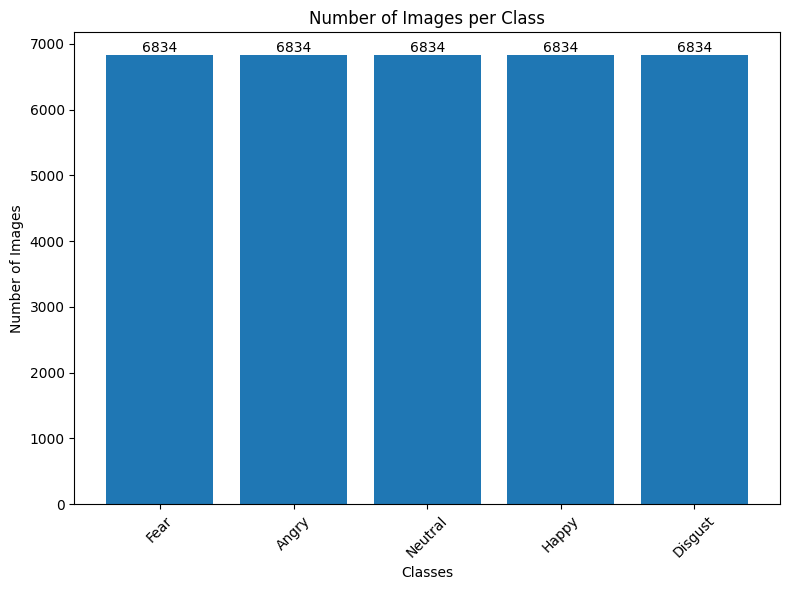

In [ ]:
plot_bar_image_at_each_class(augmented_output_dir)

### Plot the Correlation (Mutual Information) using Heatmap for each class

In [ ]:
def plot_mi_heatmap(mi_matrix, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        mi_matrix,
        xticklabels=class_names,
        yticklabels=class_names,
        cmap='bone_r',  # Grayscale gradient similar to the image
        annot=True,
        fmt='.0f',
        cbar=True
    )
    plt.title("Heatmap of Mutual Information Between Classes")
    plt.xlabel("Class")
    plt.ylabel("Class")
    plt.tight_layout()
    plt.show()

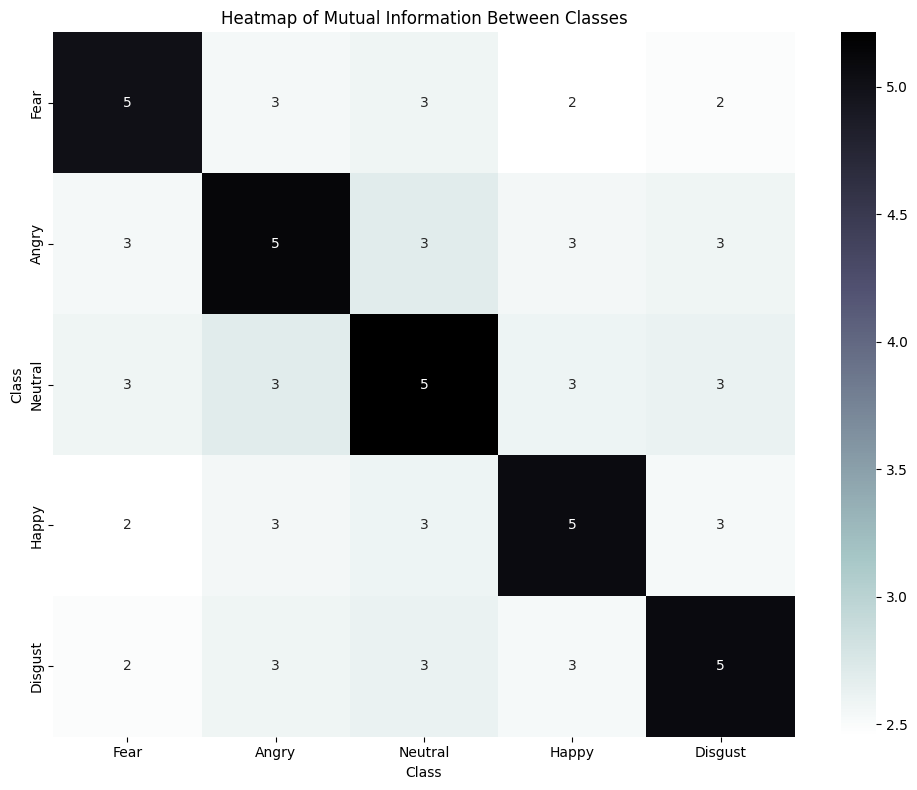

In [ ]:
# # Get all class folders
class_folders = [d for d in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, d))]

# Load one random image per class
images = {}
for class_name in class_folders:
    img, _ = load_random_image_from_class(class_name)
    images[class_name] = img

# Compute mutual information matrix
n = len(images)
mi_matrix = np.zeros((n, n))
class_names = list(images.keys())

for i in range(n):
    for j in range(n):
        mi_matrix[i, j] = calculate_mutual_information(images[class_names[i]], images[class_names[j]])
plot_mi_heatmap(mi_matrix, classes)

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import random
# #
# def visualize_augmented_images(images, labels, class_names, num_samples=10):
#     plt.figure(figsize=(15, 5))

#     indices = random.sample(range(len(images)), num_samples)

#     for i, idx in enumerate(indices):
#         img = images[idx].squeeze()  # remove channel dim if (48, 48, 1)
#         label = np.argmax(labels[idx])  # convert one-hot back to class index
#         class_name = class_names[label]

#         plt.subplot(1, num_samples, i + 1)
#         plt.imshow(img, cmap='gray')
#         plt.title(class_name)
#         plt.axis('off')

#     plt.tight_layout()
#     plt.show()

# visualize_augmented_images(X_train_aug_srgans, y_train_aug_srgans, class_names)

### Visualize Samples of Images with High Resolution

In [ ]:
#Visualize Super-Resolution Results
def visualize_srgan(generator, lr_imgs, hr_imgs, samples=5):
    for i in range(samples):
        lr = lr_imgs[i]
        hr = hr_imgs[i]
        sr = generator.predict(np.expand_dims(lr, axis=0))[0]

        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(lr.squeeze(), cmap='gray')
        axs[0].set_title("Low Resolution")
        axs[1].imshow(sr.squeeze(), cmap='gray')
        axs[1].set_title("Super-Resolved")
        axs[2].imshow(hr.squeeze(), cmap='gray')
        axs[2].set_title("High Resolution")

        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

In [ ]:
# vgg = build_vgg(input_shape=(192, 192, 3))
# srgan = compile_srgan(gen, disc, vgg, lr_shape, hr_shape)

# visualize_srgan(gen, lr_imgs, hr_imgs, samples=5)


NameError: name 'build_vgg' is not defined

### Grad-CAM to Detect the Influence Features During Prediction

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cv2


In [ ]:
data_dir = "/content/drive/MyDrive/Data_Visualization/Course_Project/augmented_images"

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # convert to 1-channel
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # normalize to [-1, 1]
])

dataset = ImageFolder(root=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
class_names = dataset.classes


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, len(class_names))

model = model.to(device)
model.eval()


In [ ]:
def gradcam_with_prediction(model, image_tensor, class_names, target_layer='layer4'):
    import torch
    import numpy as np
    import matplotlib.pyplot as plt
    import cv2

    model.eval()
    image_tensor = image_tensor.to(next(model.parameters()).device)

    # Forward pass and hook
    activations = {}
    gradients = {}

    def forward_hook(module, input, output):
        activations['value'] = output

    def backward_hook(module, grad_input, grad_output):
        gradients['value'] = grad_output[0]

    # Register hooks on the desired layer
    for name, module in model.named_modules():
        if name == target_layer:
            module.register_forward_hook(forward_hook)
            module.register_backward_hook(backward_hook)
            break
    else:
        raise ValueError(f"Layer '{target_layer}' not found in model.")

    # Forward + backward
    output = model(image_tensor)
    pred_class = output.argmax(dim=1).item()
    class_label = class_names[pred_class]
    score = output[0, pred_class]

    model.zero_grad()
    score.backward()

    # Grad-CAM calculation
    grad = gradients['value'][0]
    act = activations['value'][0]
    weights = grad.mean(dim=(1, 2))
    cam = torch.zeros(act.shape[1:], dtype=torch.float32).to(act.device)
    for i, w in enumerate(weights):
        cam += w * act[i]

    cam = torch.relu(cam)
    cam = cam - cam.min()
    cam = cam / cam.max() if cam.max() > 0 else cam
    cam = cam.detach().cpu().numpy()

    # Prepare input image for display
    img = image_tensor.cpu().squeeze().numpy()
    if img.ndim == 2:
        img = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
    else:
        img = np.transpose(img, (1, 2, 0))
        img = (img * 255).astype(np.uint8)

    # Create Grad-CAM overlay
    cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Plot results
    fig, axs = plt.subplots(1, 3, figsize=(14, 4))

    axs[0].imshow(img)
    axs[0].set_title("Input Image")
    axs[0].axis('off')

    probs = output[0].softmax(dim=0).detach().cpu().numpy()
    axs[1].barh(class_names, probs)
    axs[1].set_title("Predicted Class")
    axs[1].axvline(x=probs[pred_class], color='gray', linestyle='--')
    axs[1].invert_yaxis()

    axs[2].imshow(overlay)
    axs[2].set_title(f"Grad-CAM: {class_label}")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
images, labels = next(iter(dataloader))  # images: [B, C, H, W]
gradcam_with_prediction(model, images[0].unsqueeze(0), class_names)

## Predictive Analysis for Comparision Analysis to Check the Performance before and after Image Preprocessing ( Image Augmentation and Improving Resolution)

### Data Preprocessing

In [ ]:
import tensorflow as tf
from keras.optimizers import Adam, SGD, RMSprop, Lion
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

In [ ]:
def load_images_from_folder(images_dir, image_size):
    images, labels = [], []
    class_names = sorted(entry for entry in os.listdir(images_dir)
                         if os.path.isdir(os.path.join(images_dir, entry)))
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}

    for cls_name in class_names:
        cls_path = os.path.join(images_dir, cls_name)
        for img_file in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                resized_img = cv2.resize(img, image_size)
                images.append(resized_img)
                labels.append(class_to_idx[cls_name])

    return np.array(images), np.array(labels), class_names

In [ ]:
def image_preprocessing(images_dir, image_size):
    images, labels, class_names = load_images_from_folder(images_dir, image_size)
    images = images.astype('float32') / 255.0
    images = np.expand_dims(images, -1)
    labels = tf.keras.utils.to_categorical(labels, len(class_names))
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test, class_names


In [ ]:
## Loading and Preprocessing Orginal Images

X_train, X_test, y_train, y_test, class_names= image_preprocessing(original_images_dir, (48, 48))

print('X_train Size=', X_train.shape)
print('X_test Size=', X_test.shape)
print('y_train Size=', y_train.shape)
print('y_test Size=', y_test.shape)
print('class_names Size=', len(class_names))

In [ ]:
## Loading and Preprocessing Images after Augmentation and SRGANs

X_train_aug_srgans, X_test_aug_srgans, y_train_aug_srgans, y_test_aug_srgans,class_names_aug_srgans= image_preprocessing(augmented_output_dir, (192,192))

print('X_train Size=', X_train_aug_srgans.shape)
print('X_test Size=', X_test_aug_srgans.shape)
print('y_train Size=', X_test_aug_srgans.shape)
print('y_test Size=', y_train_aug_srgans.shape)
print('class_names Size=', len(class_names_aug_srgans))

### CNN Model

#### Building CNN Model

In [ ]:
# Building the Model Articture
from tensorflow.keras.metrics import Precision, Recall


def cnn_model(input_shape, num_classes=5):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(), Recall()])
    model.summary()

    return model



#### Train CNN Model

In [ ]:
def train_model(model, X_train, y_train, X_test, y_test, epochs, batch_size):
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=epochs, batch_size=batch_size)
    return history

In [ ]:
# Train Original Model

X_train, X_test, y_train, y_test, class_names = image_preprocessing(original_images_dir, (48,48))

model = cnn_model(input_shape=(48, 48, 1), num_classes=len(class_names))

history = train_model(model, X_train, y_train, X_test, y_test, epochs=20, batch_size=32)

In [ ]:
# Train Image with Augmentation and SRGANs
X_train_aug_srgans, X_test_aug_srgans, y_train_aug_srgans, y_test_aug_srgans, class_names = image_preprocessing(augmented_output_dir, (192,192))

aug_srgans_model = cnn_model(input_shape=(192, 192, 1), num_classes=len(class_names))

history_aug_srgans_model = train_model(
    aug_srgans_model,
    X_train_aug_srgans,
    y_train_aug_srgans,
    X_test_aug_srgans,
    y_test_aug_srgans,
    epochs=20,
    batch_size=32
)


In [ ]:
# Train Image with SRGANs only
X_train_srgans, X_test_srgans, y_train_srgans, y_test_srgans, class_names_srgans = image_preprocessing(srgan_output_dir, (192,192))


srgans_model = cnn_model(input_shape=(192, 192, 1), num_classes=len(class_names_srgans))

history_aug_srgans_model = train_model(
    srgans_model,
    X_train_srgans,
    y_train_srgans,
    X_test_srgans,
    y_test_srgans,
    epochs=20,
    batch_size=32
)


In [ ]:
# Train Image with Augmented Orginal Images only
X_train_aug, X_test_aug, y_train_aug, y_test_aug, class_names_aug = image_preprocessing(augmented_with_orginal_images_dir, (48,48))


aug_model = cnn_model(input_shape=(48, 48, 1), num_classes=len(class_names_aug))

history_aug_srgans_model = train_model(
    aug_model,
    X_train_aug,
    y_train_aug,
    X_test_aug,
    y_test_aug,
    epochs=20,
    batch_size=32
)


#### CNN Model Prediction and Evaluation Metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def model_evaluation(model, X_test, y_test, class_names):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_classes)
    precision = precision_score(np.argmax(y_test, axis=1), y_pred_classes, average='weighted')
    recall = recall_score(np.argmax(y_test, axis=1), y_pred_classes, average='weighted')
    f1 = f1_score(np.argmax(y_test, axis=1), y_pred_classes, average='weighted')

    return accuracy, precision, recall, f1

In [ ]:
# Evaluate Model before Applying Augmentation and SRGANs

orginal_model_accuracy, orginal_model_precision, orginal_model_recall, orginal_model_f1 = model_evaluation(model, X_test, y_test, class_names = image_preprocessing(original_images_dir, (48,48)))

print(f"Model Accuracy Before Augmentation and SRGANs : {orginal_model_accuracy:.2f}")
print(f"Original Model Precision Before Augmentation and SRGANs:{orginal_model_precision:.2f}")
print(f"Original Model Recall Before Augmentation and SRGANs:{orginal_model_recall:.2f}")
print(f"Original Model F1 Score Before Augmentation and SRGANs:{orginal_model_f1:.2f}")


In [ ]:
#Evaluate Model after Applying Augmentation and SRGANs

aug_srgans_model_accuracy, aug_srgans_model_precision, aug_srgans_model_recall, aug_srgans_model_f1 = model_evaluation(aug_srgans_model, X_test_aug_srgans, y_test_aug_srgans, class_names = image_preprocessing(augmented_output_dir, (192,192)))

print(f"Model Accuracy After Augmentation and SRGANs : {aug_srgans_model_accuracy:.2f}")
print(f"Model Precision After Augmentation and SRGANs:{aug_srgans_model_precision:.2f}")
print(f"Model Recall After Augmentation and SRGANs:{aug_srgans_model_recall:.2f}")
print(f"Model F1 Score After Augmentation and SRGANs:{aug_srgans_model_f1:.2f}")




In [ ]:
#Evaluate Model after Applying SRGANs Only

srgans_model_accuracy, srgans_model_precision, srgans_model_recall, srgans_model_f1 = model_evaluation(srgans_model, X_test_srgans, y_test_srgans, class_names_srgans)

print(f"Model Accuracy After SRGANs Only : {srgans_model_accuracy:.2f}")
print(f"Model Precision After SRGANs Only:{srgans_model_precision:.2f}")
print(f"Model Recall After SRGANs Only:{srgans_model_recall:.2f}")
print(f"Model F1 Score After SRGANs Only:{srgans_model_f1:.2f}")


In [ ]:
#Evaluate Model after Applying Augmented the Orginal Images Only

aug_model_accuracy, aug_model_precision, aug_model_recall, aug_model_f1 = model_evaluation(aug_model, X_test_aug, y_test_aug, class_names_aug)

print(f"Model Accuracy After Augmented Orginal Images Only : {aug_model_accuracy:.2f}")
print(f"Model Precision After Augmented Orginal Images Only:{aug_model_precision:.2f}")
print(f"Model Recall After Augmented Orginal Images Only:{aug_model_recall:.2f}")
print(f"Model F1 Score After Augmented Orginal Images Only:{aug_model_f1:.2f}")

In [ ]:
# Confusion Materix

def confusion_matrix_plot(model, title, X_test, y_test, class_names):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        mi_matrix,
        xticklabels=class_names,
        yticklabels=class_names,
        cmap='bone_r',  # Grayscale gradient similar to the image
        annot=True,
        fmt='.0f',
        cbar=True
    )
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix of {title}')

    plt.show()



In [ ]:
# Confusion Matrix Before SRGANs and Augmentation

confusion_matrix_plot(model, 'Model Before SRGANs and Augmentation', X_test, y_test, class_names)

In [ ]:
# Confusion Matrix After SRGANs and Augmentation

confusion_matrix_plot(aug_srgans_model, 'Model After SRGANs and Augmentation', X_test_aug_srgans, y_test_aug_srgans, class_names_aug_srgans)

In [ ]:
# Confusion Matrix After SRGANs Only

confusion_matrix_plot(srgans_model, 'Model After SRGANs Only', X_test_srgans, y_test_srgans, class_names_srgans)

In [ ]:
#Evaluate Model of Augmentation with Orginal Images

confusion_matrix_plot(aug_model, 'Model After Augmentation with Orginal Images', X_test_aug, y_test_aug, class_names_aug)